# Tarea 1 Aprendizaje Automático UCV 02-2025
#### Jhonatan Homsany C.I. 30.182.893
#####Regresión logística.

# *League of Legends.*

El acercamiento que se estará manejando basa su funcionamiento en utilizar estrategias de selección de variables para eliminar las características menos informativas de nuestro conjunto de datos. Trabajar con datos "limpios" o con un ruido reducido y controlado nos permitirá aplicar posteriormente las estrategias conocidas de regresión logística para así clasificar cada partida y predecir su ganador.

En esta ocasión, nuestras predicciones estarán en el conjunto $P = \{``blueWins", ``redWins"\}$.

#Carga de datos.

In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cedula = 30182893
np.random.seed(cedula)
url = 'https://raw.githubusercontent.com/JhonatanHZ/ML-UCV-02-2025/main/Tarea%201/high_diamond_ranked_10min.csv'

df = pd.read_csv(url)
df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


#Separación de variables.

In [67]:
y = df['blueWins']
X = df.drop(['gameId', 'blueWins'], axis=1)

# División del dataset.

Note que el $70\%$ de los datos serán usados para entrenamiento y el otro $30\%$ para pruebas.

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=cedula
)

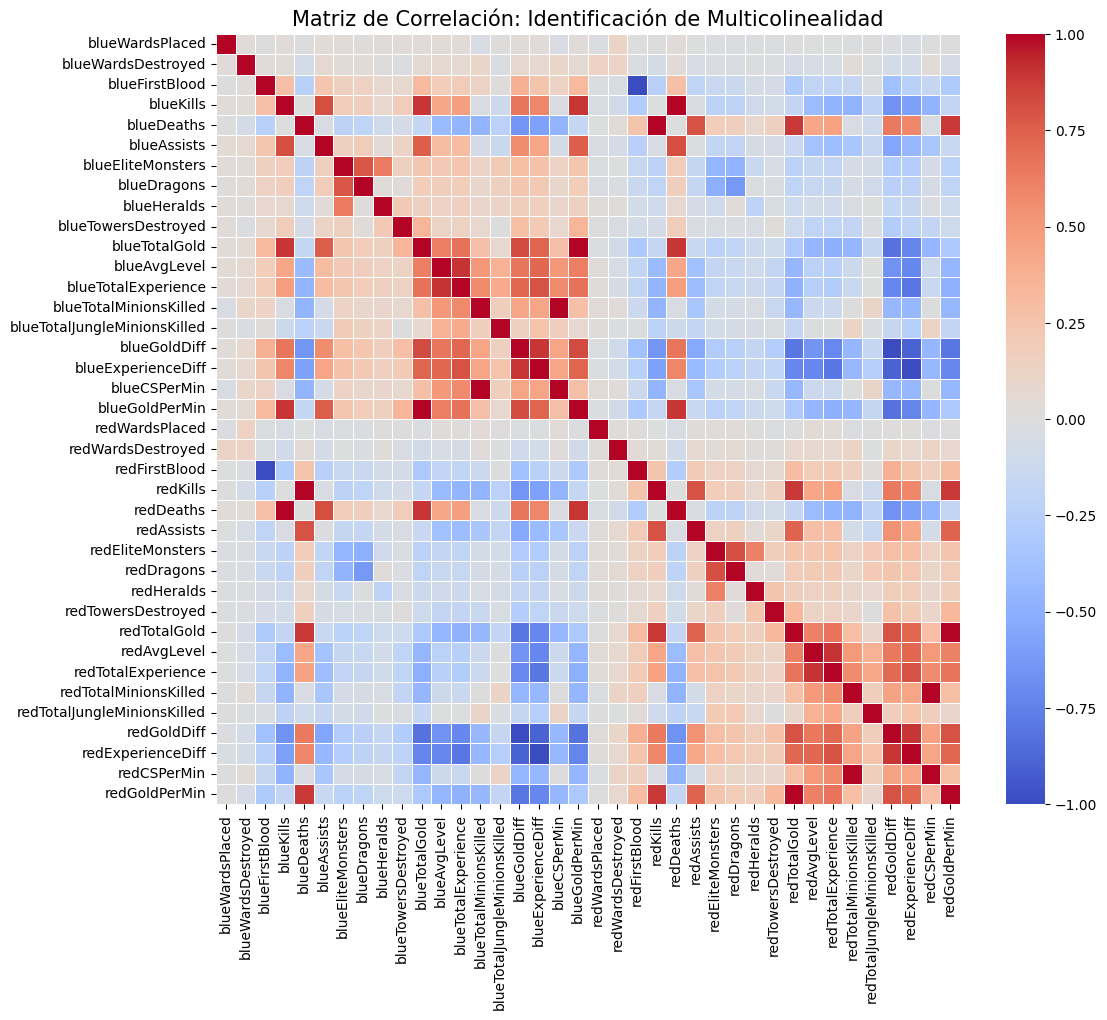

In [69]:
plt.figure(figsize=(12, 10))
correlation_matrix = X_train.corr()

sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, linewidths=.5)

plt.title('Matriz de Correlación: Identificación de Multicolinealidad', fontsize=15)
plt.show()

Observando la matriz de correlación, es posible notar una fuerte relación positiva entre las variables $blueTotalGold$, $blueExperience$ y $blueTotalMinionsKilled$. Esto refleja los componentes principales del juego donde una mayor eficiencia en la eliminación de súbditos conlleva a la progresión de niveles y recursos económicos. Por otro lado, la variable $blueGoldDiff$ presenta la correlación más significativa con el objetivo $blueWins$, indicando que la diferencia neta de oro a los $10$ minutos es el predictor más robusto de la victoria final.

#Pipelines.

### Elastic Net.

Para la selección de variables se ha decidido utilizar Elastic Net para así aprovechar las mejores características de LASSO y las mejores características de Ridge.

Dado que estamos trabajando con un dataset complejo con ruido, LASSO representa una buena opción para eliminar las variables que no aportan información relevante para predecir el ganador de la partida. Tras esto, Ridge aporta estabilidad al modelo frente a la multicolinealidad balanceando el ruido restante de manera que las variables más informativas tengan un mayor peso en la predicción gracias a la penalización de su geometría cuadrática.

In [70]:
pipeline_elastic = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectFromModel(LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=0.1))),
    ('clf', LogisticRegression(solver='liblinear', max_iter=100, random_state=cedula))
])

### Eliminación recursiva de características.

La eliminación recursiva de características es un método con un acercamiento voraz en el que se disminuye la cantidad de características recibidas en la entrada a través de la eliminación de características menos informativas. Funciona considerando conjuntos cada vez más pequeños de características.

Es un proceso recursivo y voraz. Por lo tanto, el método se basa en eliminar la característica que menos información aporta en la iteración $i$ y repetir el procedimiento con este nuevo conjunto de datos hasta tener el número deseado de características.

In [71]:
pipeline_rfe = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', RFE(estimator=LogisticRegression(solver='liblinear'), n_features_to_select=10)),
    ('clf', LogisticRegression(solver='liblinear', max_iter=100, random_state=cedula))
])

# Entrenamiento de los modelos.

In [72]:
pipeline_rfe.fit(X_train, y_train)

score = pipeline_rfe.score(X_test, y_test)
print(f"Exactitud del modelo (RFE): {score:.4f}")

pipeline_elastic.fit(X_train, y_train)

score = pipeline_elastic.score(X_test, y_test)
print(f"Exactitud del modelo (Elastic Net): {score:.4f}")

Exactitud del modelo (RFE): 0.7277
Exactitud del modelo (Elastic Net): 0.7267


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#Selección del modelo usando validación cruzada.

### Elastic Net.

In [59]:
param_grid_elastic = {
    'selector__estimator__C': [0.01, 0.1, 1.0],
    'selector__estimator__l1_ratio': [0.2, 0.5, 0.8]
}

grid_elastic = GridSearchCV(
    pipeline_elastic,
    param_grid_elastic,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_elastic.fit(X_train, y_train)

print(f"Mejores parámetros Elastic Net: {grid_elastic.best_params_}")
print(f"Mejor score de validación: {grid_elastic.best_score_:.4f}")

Mejores parámetros Elastic Net: {'selector__estimator__C': 0.01, 'selector__estimator__l1_ratio': 0.8}
Mejor score de validación: 0.7364


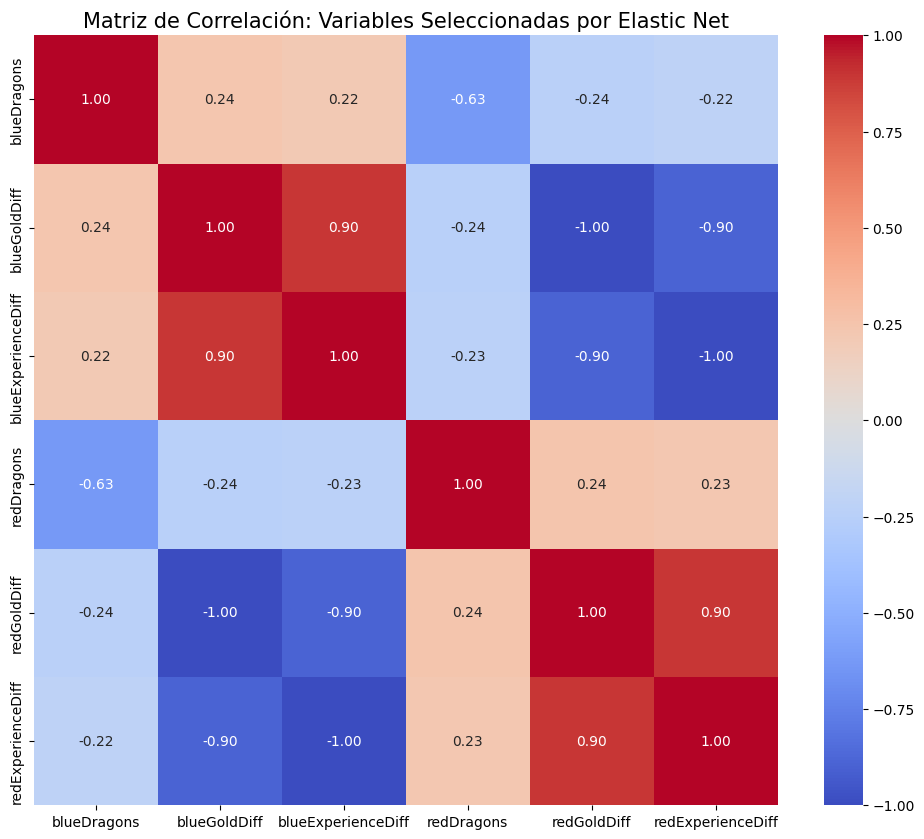

Variables originales: 38
Variables tras Elastic Net: 6


In [60]:
best_elastic = grid_elastic.best_estimator_
selector = best_elastic.named_steps['selector']
selected_features_mask = selector.get_support()
selected_features_names = X.columns[selected_features_mask]
plt.figure(figsize=(12, 10))
corr_post_elastic = X_train[selected_features_names].corr()

sns.heatmap(corr_post_elastic, annot=True, cmap='coolwarm', fmt=".2f", center=0)

plt.title('Matriz de Correlación: Variables Seleccionadas por Elastic Net', fontsize=15)
plt.show()

print(f"Variables originales: {X_train.shape[1]}")
print(f"Variables tras Elastic Net: {len(selected_features_names)}")

La matriz de correlación tras la aplicación de Elastic Net revela la eliminación de $32$ variables redundantes o no informativas en el dataset original, indicando que únicamente $6$ variables son las que aportan información para la predicción que queremos realizar. Mientras que en el análisis inicial observamos una multicolinealidad severa entre el farm, el oro y el nivel, el modelo regularizado selecciona únicamente aquellas características que ofrecen una señal independiente y significativa. Esto permite identificar que la diferencia económica y de experiencia son factores fundamentales para predecir el ganador de la partida transcurridos los $10$ minutos iniciales.

### Eliminación recursiva de características.

In [61]:
param_grid_rfe = {
    'selector__n_features_to_select': [6, 10, 16, 20]
}

grid_rfe = GridSearchCV(
    pipeline_rfe,
    param_grid_rfe,
    cv=5,
    scoring='accuracy'
)

grid_rfe.fit(X_train, y_train)

print(f"Mejor número de variables (RFE): {grid_rfe.best_params_}")
print(f"Mejor score de validación: {grid_rfe.best_score_:.4f}")

Mejor número de variables (RFE): {'selector__n_features_to_select': 10}
Mejor score de validación: 0.7362


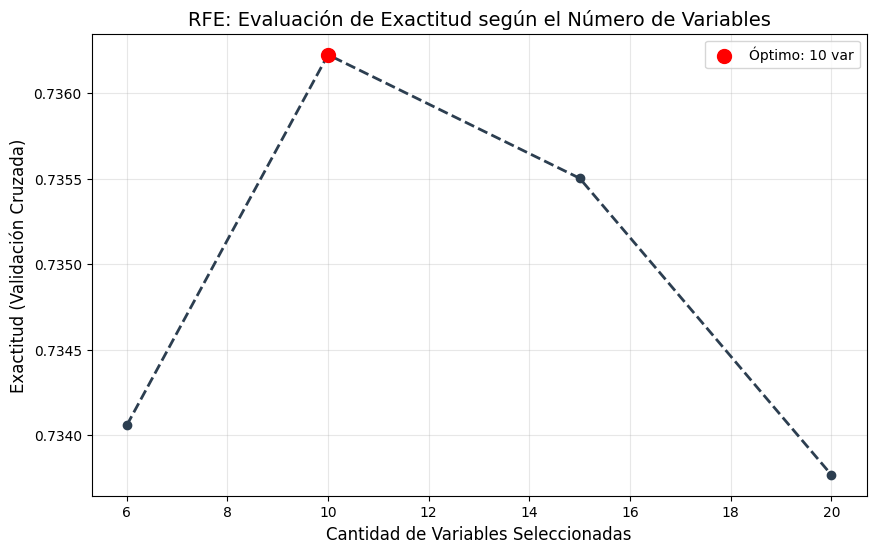

In [62]:
resultados_rfe = pd.DataFrame(grid_rfe.cv_results_)
x = resultados_rfe['param_selector__n_features_to_select'].astype(int)
y = resultados_rfe['mean_test_score']

plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='--', color='#2c3e50', linewidth=2)

best_x = grid_rfe.best_params_['selector__n_features_to_select']
best_y = grid_rfe.best_score_
plt.scatter(best_x, best_y, color='red', s=100, label=f'Óptimo: {best_x} var', zorder=5)

plt.title('RFE: Evaluación de Exactitud según el Número de Variables', fontsize=14)
plt.xlabel('Cantidad de Variables Seleccionadas', fontsize=12)
plt.ylabel('Exactitud (Validación Cruzada)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

A diferencia de Elastic Net, el método de eliminación recursiva de características realiza la reducción hasta llegar a un número de variables que ha sido establecido previamente. Por esta razón, medimos el rendimiento del modelo en función de la cantidad de características que se han mantenido.

En este caso particular, notamos que el modelo posee una mayor exactitud cuando se realiza la reducción hasta mantener únicamente $10$ variables significativas. De acuerdo a lo visto anteriormente con Elastic Net, el conjunto de datos posee seis variables informativas que son relevantes y esenciales para realizar la predicción una vez han transcurrido los $10$ minutos iniciales.

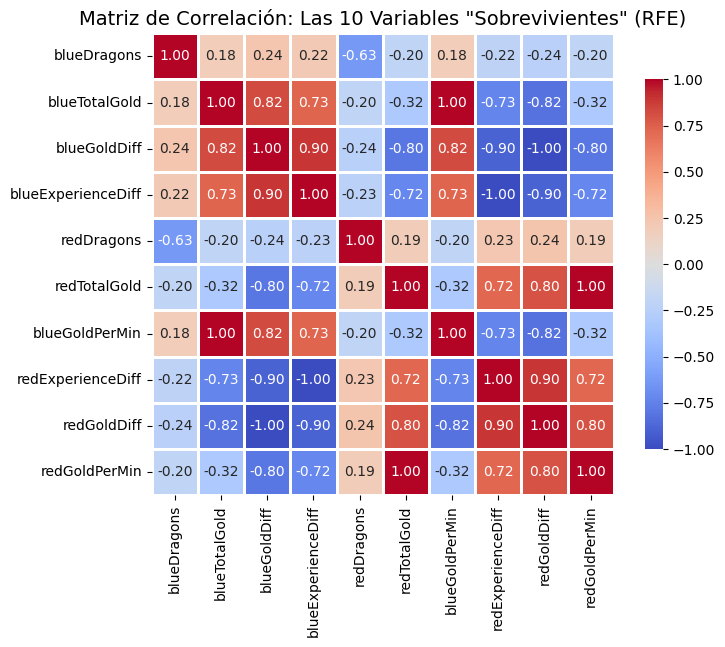

Las 10 variables que más influyen según RFE son:
['blueDragons', 'blueTotalGold', 'blueGoldDiff', 'blueExperienceDiff', 'redDragons', 'redTotalGold', 'blueGoldPerMin', 'redExperienceDiff', 'redGoldDiff', 'redGoldPerMin']


In [75]:
selector_rfe = grid_rfe.best_estimator_.named_steps['selector']
ranking = selector_rfe.ranking_

feature_importance = pd.DataFrame({'Variable': X.columns, 'Ranking': ranking}).sort_values(by='Ranking')

top_ten_features = feature_importance['Variable'].head(10).values

plt.figure(figsize=(8, 6))
corr_top5 = X_train[top_ten_features].corr()

sns.heatmap(corr_top5, annot=True, cmap='coolwarm', fmt=".2f", center=0, square=True, linewidths=1, cbar_kws={"shrink": .8})

plt.title('Matriz de Correlación: Las 10 Variables "Sobrevivientes" (RFE)', fontsize=14)
plt.show()

print("Las 10 variables que más influyen según RFE son:")
print(list(top_ten_features))

Mientras Elastic Net elimina el ruido y equilibra las variables no informativas, el método eliminación recursiva de características opta por un conjunto más amplio de $10$ variables, algunas con redundancia como por ejemplo, oro total y oro por minuto. Esta redundancia en la eliminación recursiva de características es la que permite alcanzar un pico de exactitud superior, capturando matices que el modelo regularizado de Elastic Net omite en favor de la simplicidad. En ambos casos, la permanencia de los Dragones como variables independientes subraya que el éxito en el early game depende de una combinación de eficiencia económica y control de objetivos.

# Comparación.

In [64]:
acc_elastic = grid_elastic.score(X_test, y_test)
acc_rfe = grid_rfe.score(X_test, y_test)

print(f"Exactitud Final en Test (Elastic Net Optimizado): {acc_elastic:.4f}")
print(f"Exactitud Final en Test (RFE Optimizado): {acc_rfe:.4f}")

Exactitud Final en Test (Elastic Net Optimizado): 0.7274
Exactitud Final en Test (RFE Optimizado): 0.7277


# Evaluación.

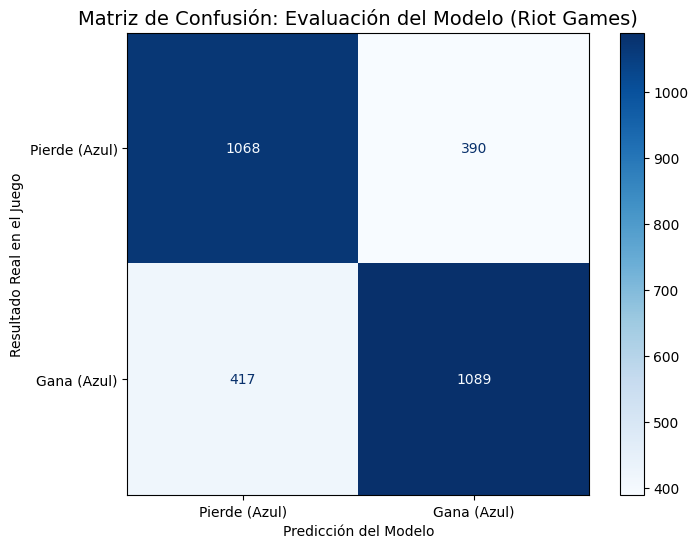

In [65]:
y_pred = grid_rfe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Pierde (Azul)', 'Gana (Azul)'])
disp.plot(cmap='Blues', ax=ax, values_format='d')

plt.title('Matriz de Confusión: Evaluación del Modelo (Riot Games)', fontsize=14)
plt.xlabel('Predicción del Modelo')
plt.ylabel('Resultado Real en el Juego')
plt.show()

Cómo se puede observar, el modelo logra predecir correctamente $1068$ escenarios en los que el equipo azul termina perdiendo la partida y en $1089$ de los casos predice su victoria correctamente. Esta simetría en el acierto indica que el modelo no está sesgado hacia ninguna clase y tiene una capacidad predictiva equilibrada, a pesar de la alta volatilidad y duración extendida que pueden tener las partidas.